In [2]:
import json
from dataclasses import dataclass
from typing import Any, Dict, List

import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

from shared import dataset_local_path, TODO

In [3]:
examples = []
ys = []

with open(dataset_local_path("poetry_id.jsonl")) as fp:
    for line in fp:
        info = json.loads(line)
        # Note: the data contains a whole bunch of extra stuff; we just want numeric features for now.
        keep = info["features"]
        # whether or not it's poetry is our label.
        ys.append(info["poetry"])
        # hold onto this single dictionary.
        examples.append(keep)

In [4]:
feature_numbering = DictVectorizer(sort=True)
feature_numbering.fit(examples)
X = feature_numbering.transform(examples)
# The above two lines is the same as 
# X = feature_numbering.fit_transform(examples)

print("Features as {} matrix.".format(X.shape))

Features as (2772, 38) matrix.


In [5]:
RANDOM_SEED = 999999

In [6]:
y = np.array(ys)

# First split the data into training and testing
X_tv, X_test, y_tv, y_test = train_test_split(
    X, y, train_size=0.75, shuffle=True, random_state=RANDOM_SEED
)
# Then split the training data into training and validations
X_train, X_vali, y_train, y_vali = train_test_split(
    X_tv, y_tv, train_size=0.66, shuffle=True, random_state=RANDOM_SEED
)

In [7]:
# Decision tree parameters
params = {
    "criterion": "gini",
    "splitter": "best",
    "max_depth": 5,
}

In [28]:
# Number of traning with different models for each one
N_MODELS = 100
# Number of sampling done for one of the models
N_SAMPLES = 100

In [29]:
seed_based_accuracies = []
for randomness in range(N_MODELS):
    # ** unpacks a dictionary into the input of a function call
    f_seed = DecisionTreeClassifier(random_state = RANDOM_SEED + randomness, **params)
    f_seed.fit(X_train, y_train)
    seed_based_accuracies.append(f_seed.score(X_vali, y_vali))

In [30]:
bootstrap_based_accuracies = []
f_single = DecisionTreeClassifier(random_state = RANDOM_SEED, **params)
f_single.fit(X_train, y_train)
y_pred = f_single.predict(X_vali)

In [31]:
for trial in range(N_SAMPLES):
    sample_pred, sample_truth = resample(y_pred, y_vali, random_state = RANDOM_SEED+trial)
    score = accuracy_score(y_true=sample_truth, y_pred=sample_pred)
    bootstrap_based_accuracies.append(score)

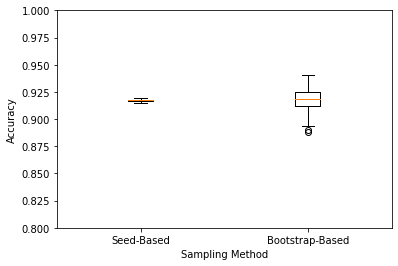

In [32]:
boxplot_data = [seed_based_accuracies, bootstrap_based_accuracies]
plt.boxplot(boxplot_data)
plt.xticks(ticks=[1, 2], labels=["Seed-Based", "Bootstrap-Based"])
plt.xlabel("Sampling Method")
plt.ylabel("Accuracy")
plt.ylim([0.8, 1.0])
plt.show()

1. The bounds created by the seed based approach represents the range of accuracy scores of the 
    entire models. While the bounds created by the booystrap approach shows the distribution of the
    data within a model and demonstrates the range of accuracy scores of subsets of the model.
    
2. a) Since the variance in the seed based approach is rather small, we cn infer that the diffrence 
    between the data of the models are not large, which suggests that the overall variance is close 
    to that of one model with K samples